In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
from PIL import Image

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

ImportError: No module named 'mrcnn.config'; 'mrcnn' is not a package

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM =800
    IMAGE_MAX_DIM =1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4 * 6, 8 * 6, 16 * 6,32 * 6, 64 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH =32

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10


config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [4]:
class DrugDataset(utils.Dataset):

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_json_get_labels_form(self,image_id):
        info = self.image_info[image_id]
        with open(info['json_path']) as f:
            data = json.load(f)
        data_info = data['objects']
        count_list = []
        labels_form = []
        for i in range(len(data_info)):
            count_list.append(data_info[i]['label'])
        for i in count_list:
            if i == 33 or i == 161:
                labels_form.append(('car'))
            elif i == 34 or i == 162:
                labels_form.append('motorbicycle')
            elif i == 35 or i == 163:
                labels_form.append(('bicycle'))
            elif i == 36 or i == 164:
                labels_form.append('person')
            elif i == 37 or i == 165:
                labels_form.append(('rider'))
            elif i == 38 or i == 166:
                labels_form.append('truck')
            elif i == 39 or i == 167:
                labels_form.append(('bus'))
            elif i == 40 or i == 168:
                labels_form.append('tricycle')
#             elif i == 49:
#                 labels_form.append(('road'))
#             elif i == 50:
#                 labels_form.append('siderwalk')
#             elif i == 65:
#                 labels_form.append(('traffic_cone'))
#             elif i == 66:
#                 labels_form.append('road_pile')
#             elif i == 67:
#                 labels_form.append(('fence'))
#             elif i == 81:
#                 labels_form.append('traffic_light')
#             elif i == 82:
#                 labels_form.append(('pole'))
#             elif i == 83:
#                 labels_form.append('traffic_sign')
#             elif i == 84:
#                 labels_form.append(('wall'))
#             elif i == 85:
#                 labels_form.append('dustbin')
#             elif i == 86:
#                 labels_form.append(('billboard'))
#             elif i == 97:
#                 labels_form.append('building')
#             elif i == 113:
#                 labels_form.append('vegatation')
        labels_form_re=[]
        for i in labels_form:
            if i not in labels_form_re:
                labels_form_re.append(i)
        num_obj=len(labels_form_re)
        return labels_form_re,num_obj
    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image,image_id):

        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == 33 or at_pixel == 161:
                        mask[j, i, index] = 1
                    elif at_pixel == 34 or at_pixel == 162:
                        mask[j, i, index] = 1
                    elif at_pixel == 35 or at_pixel == 163:
                        mask[j, i, index] = 1
                    elif at_pixel == 36 or at_pixel == 164:
                        mask[j, i, index] = 1
                    elif at_pixel == 37 or at_pixel == 165:
                        mask[j, i, index] = 1
                    elif at_pixel == 38 or at_pixel == 166:
                        mask[j, i, index] = 1
                    elif at_pixel == 39 or at_pixel == 167:
                        mask[j, i, index] = 1
                    elif at_pixel == 40 or at_pixel == 168:
                        mask[j, i, index] = 1
                    # elif at_pixel == 49:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 50:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 65:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 66:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 67:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 81:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 82:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 83:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 84:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 85:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 86:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 97:
                    #     mask[j, i, index] = 1
                    # elif at_pixel == 113:
                    #     mask[j, i, index] = 1
                    else:
                        mask[j, i, index] = 0
        return mask




    def load_shapes(self, count, width,height,img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
      # self.add_class("shapes", 1, "sky")
        self.add_class("shapes", 2, "car")
        self.add_class("shapes", 3, "motorbicycle")
        self.add_class("shapes", 4, "bicycle")
        self.add_class("shapes", 5, "person")
        self.add_class("shapes", 6, "rider")
        self.add_class("shapes", 7, "truck")
        self.add_class("shapes", 8, "bus")
        self.add_class("shapes", 9, "tricycle")
        # self.add_class("shapes", 10, "road")
        # self.add_class("shapes", 11, "siderwalk")
        # self.add_class("shapes", 12, "traffic_cone")
        # self.add_class("shapes", 13, "road_pile")
        # self.add_class("shapes", 14, "fence")
        # self.add_class("shapes", 15, "traffic_light")
        # self.add_class("shapes", 16, "pole")
        # self.add_class("shapes", 17, "traffic_sign")
        # self.add_class("shapes", 18, "wall")
        # self.add_class("shapes", 19, "dustbin")
        # self.add_class("shapes", 20, "billboard")
        # self.add_class("shapes", 21, "building")
        # self.add_class("shapes", 22, "vegatation")

        for i in range(count):
            # 获取图片宽和高

            filestr = imglist[i].split(".")[0]
            mask_path = mask_floder + "/" + filestr + ".png"
            json_path = mask_floder + "/" + filestr + ".json"
            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                            width=width, height=height, mask_path=mask_path,json_path=json_path)



    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        # count = 1  # number of object
        img = Image.open(info['mask_path'])
        labels_form_re,num_obj = self.from_json_get_labels_form(image_id)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img,image_id)
        # occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        # for i in range(num_obj- 2, -1, -1):
        #     mask[:, :, i] = mask[:, :, i] * occlusion
        #     occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = np.array([self.class_names.index(s) for s in labels_form_re])

        return mask, class_ids.astype(np.int32)

In [5]:
#基础设置
dataset_root_path="/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/"
img_floder = dataset_root_path + "pic"
mask_floder = dataset_root_path + "cv2_mask"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
count = len(imglist)

#train与val数据集准备
dataset_train = DrugDataset()
dataset_train.load_shapes(count,3384,2710,img_floder, mask_floder, imglist,dataset_root_path)
dataset_train.prepare()

#print("dataset_train-->",dataset_train._image_ids)

dataset_val = DrugDataset()
dataset_val.load_shapes(15,3384,2710,img_floder, mask_floder, imglist,dataset_root_path)
dataset_val.prepare()

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 3


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')


Starting at epoch 3. LR=0.001

Checkpoint Path: /home/mt/桌面/Mask_RCNN-master/logs/shapes20180925T1715/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/home/mt/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/mt/.local/lib/python3.5/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 4/10
 1/32 [..............................] - ETA: 47:31 - loss: 8.0310 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 8.0210 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

ERROR:root:Error processing image {'json_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073033913_Camera_6.json', 'path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/pic/170908_073033913_Camera_6.jpg', 'source': 'shapes', 'id': 13, 'height': 2710, 'mask_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073033913_Camera_6.png', 'width': 3384}
Traceback (most recent call last):
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1226, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/utils.py", line 457, in resize_image
    order=1, mode="constant", preserve_range=True)
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py", line 135, in resize
    preserve_range=preserve_range)
  File "/usr/local/lib/python3.5/dis

 4/32 [==>...........................] - ETA: 29:05 - loss: 17.4162 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 14.5825 - mrcnn_class_loss: 0.9308 - mrcnn_bbox_loss: 1.7680 - mrcnn_mask_loss: 0.1020            

ERROR:root:Error processing image {'json_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073040564_Camera_5.json', 'path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/pic/170908_073040564_Camera_5.jpg', 'source': 'shapes', 'id': 81, 'height': 2710, 'mask_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073040564_Camera_5.png', 'width': 3384}
Traceback (most recent call last):
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1226, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/utils.py", line 457, in resize_image
    order=1, mode="constant", preserve_range=True)
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py", line 135, in resize
    preserve_range=preserve_range)
  File "/usr/local/lib/python3.5/dis

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20,
            layers="all")

In [7]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/mt/桌面/Mask_RCNN-master/logs/shapes20180925T1722/mask_rcnn_shapes_0003.h5
Re-starting from epoch 3


In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max: 3384.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (3, 4)                min:  198.00000  max:  922.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.26542  max:    1.20286  float32


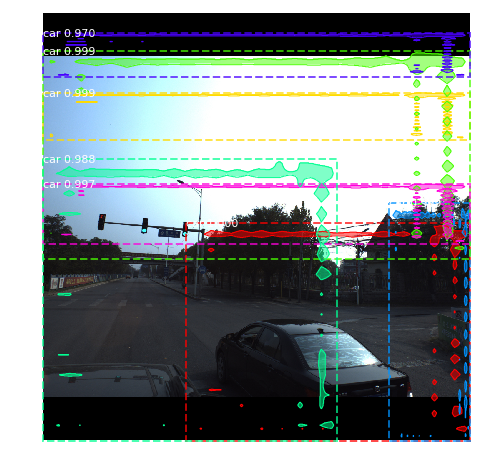

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())